In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser

In [2]:
start_day_to_analyze = '2020-02-24'
end_day_to_analyze = '2020-02-25'

In [3]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [4]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [5]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [6]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')

,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,70,algo.py,PAPER,v0.1-129-gf8519b5,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-02-24 14:45:17.860383,2020-02-24 21:10:01.117013,market close


,symbol,count,revenue,%
0,TOCA,8,32.19,1.90
1,APT,6,-88.96,-4.94
2,CTSO,5,-70.74,-1.65
3,VHC,4,27.06,0.81
4,AHPI,4,98.95,6.57
5,CBLI,3,-62.54,-3.12
6,BIMI,2,11.96,-0.18
7,TECS,2,-33.74,-1.30
8,EGO,2,-31.67,-1.24
9,HMY,2,-77.24,-2.02


TOTAL REVENUE: -51.58 $


In [13]:
minute_history = {}
for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

nan
all


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
15,CTSO,70,False,1.146132,False,0.02,0.01
29,CBLI,70,False,0.219298,False,0.01,0.01
33,TECS,70,False,0.000000,False,0.02,0.01
27,CBLI,70,False,2.927928,True,0.01,0.01
50,CODX,70,False,0.000000,False,NaN,NaN
35,EGO,70,False,0.095602,False,0.03,0.01
22,VHC,70,False,0.636364,False,0.03,0.02
37,HMY,70,False,0.186099,False,0.01,0.00
38,NNVC,70,False,1.021450,False,0.07,0.05
18,CTSO,70,False,-0.141443,False,0.02,0.01


winners analysis


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
27,CBLI,70,False,2.927928,True,0.01,0.01
15,CTSO,70,False,1.146132,False,0.02,0.01
38,NNVC,70,False,1.021450,False,0.07,0.05
29,CBLI,70,False,0.219298,False,0.01,0.01
11,APT,70,False,2.313433,True,0.03,0.03
42,LAKE,70,False,0.137457,False,0.05,0.02
16,CTSO,70,False,1.001431,False,0.02,0.01
8,APT,70,False,5.624037,True,0.03,0.03
35,EGO,70,False,0.095602,False,0.03,0.01
22,VHC,70,False,0.636364,False,0.03,0.02


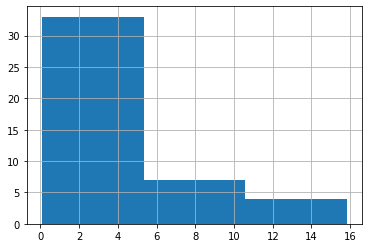

In [14]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []
scalp = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                continue
                
            if math.isnan(max_val):
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0.003]['max_val %'].hist(bins=3)


TOCA analysis for run 70
2020-02-24T15:04:54.152612038Z 2.2
2020-02-24T15:05:18.713645662Z 2.22
2020-02-24T15:06:01.688316163Z 2.28
2020-02-24T15:07:40.625175395Z 2.3
2020-02-24T15:11:02.034985406Z 2.36
2020-02-24T15:11:59.166854744Z 2.32
2020-02-24T15:13:27.431080494Z 2.38
2020-02-24T15:14:11.433564013Z 2.41


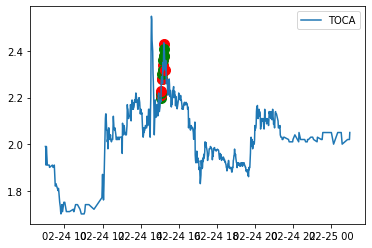

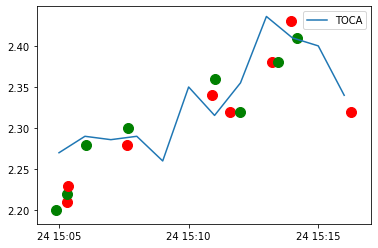

Delta = 0.03999999999999959


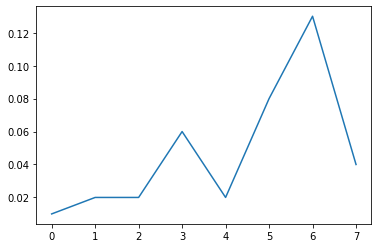

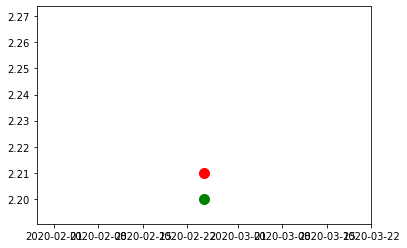

buy time:2020-02-24T15:04:54.152612038Z sell time:2020-02-24T15:05:17.61387074Z
{'rsi': 52.73520578963248, 'macd1': [0.0009708022042005382, 0.0005354533852250931, 0.0025814284884750904, 0.0040592559512671045, 0.006064285946887349], 'macd2': [0.018358663824554977, 0.017885427629482642, 0.017901238027171473, 0.017867961247072905, 0.017987896586538987], 'macd_signal': [0.00530880046254816, 0.004354131047083547, 0.0039995905353618555, 0.004011523618542906, 0.004422076084211794]}
{'rsi': 53.9439294122827, 'macd': [-0.0010690363788610213, 0.00035970825980990995, 0.0014060065722829584, 0.001870576600544016, 0.0036420522511302345], 'scalp': 0, 'bail_out': 1, 'movement': 0.004545454545454448, 'too_close': 0, 'macd_signal': [0.001067029437832349, 0.0009255652022278612, 0.0010216534762388808, 0.001191438101099908, 0.0016815609311059733], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001960491320024

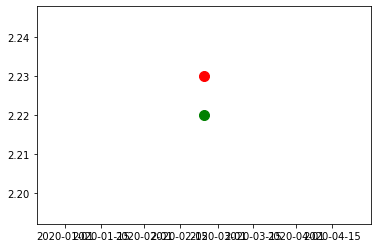

buy time:2020-02-24T15:05:18.713645662Z sell time:2020-02-24T15:05:21.638095857Z
{'rsi': 55.031972487599965, 'macd1': [0.0005354533852250931, 0.0025814284884750904, 0.0040592559512671045, 0.004660297342898634, 0.008077520115910009], 'macd2': [0.017885427629482642, 0.017901238027171473, 0.017867961247072905, 0.017706409181501126, 0.018130816642673686], 'macd_signal': [0.004354131047083547, 0.0039995905353618555, 0.004011523618542906, 0.004141278363414051, 0.004928526713913243]}
{'rsi': 56.06979348250193, 'macd': [-0.0010690363788610213, 0.00035970825980990995, 0.0014060065722829584, 0.001870576600544016, 0.004681013290091407], 'scalp': 0, 'bail_out': 1, 'movement': 0.004504504504504408, 'too_close': 0, 'macd_signal': [0.001067029437832349, 0.0009255652022278612, 0.0010216534762388808, 0.001191438101099908, 0.001889353138898208], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00279166015119

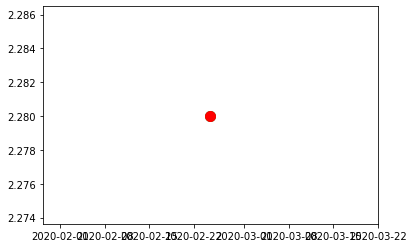

buy time:2020-02-24T15:06:01.688316163Z sell time:2020-02-24T15:07:37.556380559Z
{'rsi': 60.67726741908742, 'macd1': [0.0025814284884750904, 0.0040592559512671045, 0.004660297342898634, 0.012066124104514131, 0.018528625138777066], 'macd2': [0.017901238027171473, 0.017867961247072905, 0.017706409181501126, 0.01893049677062253, 0.02018635584918549], 'macd_signal': [0.0039995905353618555, 0.004011523618542906, 0.004141278363414051, 0.005726247511634068, 0.008286723037062668]}
{'rsi': 61.24597433870852, 'macd': [0.0014060065722829584, 0.001870576600544016, 0.006758935368013308, 0.011519228753469779, 0.014975051797286643], 'scalp': 0, 'bail_out': 1, 'movement': 0.003508771929824565, 'too_close': 0, 'macd_signal': [0.0010216534762388808, 0.001191438101099908, 0.0023049375544825883, 0.004147795794280026, 0.00631324699488135], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008661804802405294}


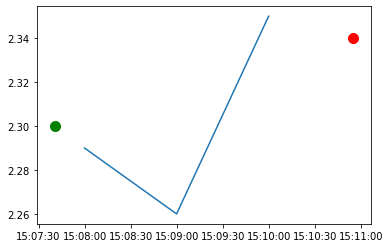

buy time:2020-02-24T15:07:40.625175395Z sell time:2020-02-24T15:10:54.748395085Z
{'rsi': 62.41398972562352, 'macd1': [0.0040592559512671045, 0.004660297342898634, 0.012066124104514131, 0.019326345936497624, 0.025592031463704146], 'macd2': [0.017867961247072905, 0.017706409181501126, 0.01893049677062253, 0.020346291874775435, 0.02177626363293461], 'macd_signal': [0.004011523618542906, 0.004141278363414051, 0.005726247511634068, 0.00844626719660678, 0.011875420050026253]}
{'rsi': 65.13255441890217, 'macd': [0.011519228753469779, 0.014865960888196028, 0.017493726695928302, 0.01775570360200618, 0.022399377767754913], 'scalp': 1, 'bail_out': 0, 'movement': 0.02169565217391307, 'too_close': 0, 'macd_signal': [0.004147795794280026, 0.006291428813063227, 0.008531888389636241, 0.010376651432110228, 0.012781196699239165], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009618181068515749}


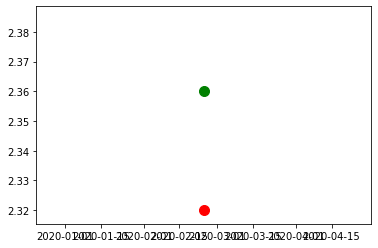

buy time:2020-02-24T15:11:02.034985406Z sell time:2020-02-24T15:11:36.472165435Z
{'rsi': 65.92697221525522, 'macd1': [0.02446724513891807, 0.0285432516919375, 0.029018262504794112, 0.036239216702846466, 0.042281397721801284], 'macd2': [0.021550753836853342, 0.022690003720657437, 0.02322205248825071, 0.025113838175687242, 0.026974111472004125], 'macd_signal': [0.011650462785069038, 0.01502902056644273, 0.017826868954113007, 0.0215093385038597, 0.025663750347448017]}
{'rsi': 60.26825277016711, 'macd': [0.014865960888196028, 0.017493726695928302, 0.01775570360200618, 0.02240457257294981, 0.023917917581828707], 'scalp': 0, 'bail_out': 0, 'movement': -0.01906779661016946, 'too_close': 0, 'macd_signal': [0.006291428813063227, 0.008531888389636241, 0.010376651432110228, 0.012782235660278144, 0.015009372044588257], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00890854553724045}


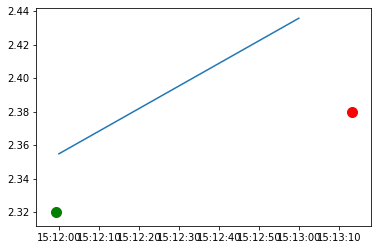

buy time:2020-02-24T15:11:59.166854744Z sell time:2020-02-24T15:13:13.295320809Z
{'rsi': 62.23649449074724, 'macd1': [0.02446724513891807, 0.0285432516919375, 0.029018262504794112, 0.036239216702846466, 0.03987228091268413], 'macd2': [0.021550753836853342, 0.022690003720657437, 0.02322205248825071, 0.025113838175687242, 0.026491104674723154], 'macd_signal': [0.011650462785069038, 0.01502902056644273, 0.017826868954113007, 0.0215093385038597, 0.025181926985624586]}
{'rsi': 65.59166703314537, 'macd': [0.01775570360200618, 0.02240457257294981, 0.02393869680260785, 0.02688036897113877, 0.030122186648291027], 'scalp': 1, 'bail_out': 0, 'movement': 0.0215469138981886, 'too_close': 0, 'macd_signal': [0.010376651432110228, 0.012782235660278144, 0.015013527888744086, 0.017386896105223024, 0.019933954213836626], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.010188232434454401}


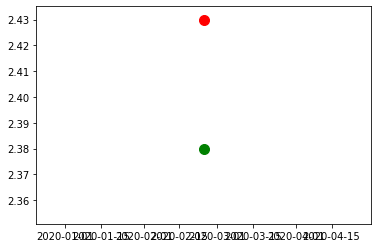

buy time:2020-02-24T15:13:27.431080494Z sell time:2020-02-24T15:13:56.539026381Z
{'rsi': 66.10202397605548, 'macd1': [0.029018262504794112, 0.036239216702846466, 0.038723562963966174, 0.0433876682914649, 0.0491001420575512], 'macd2': [0.02322205248825071, 0.025113838175687242, 0.026260796797874075, 0.02790738160493511, 0.02988945362197981], 'macd_signal': [0.017826868954113007, 0.0215093385038597, 0.024952183395880994, 0.028639280374997775, 0.03273145271150846]}
{'rsi': 69.23142339858099, 'macd': [0.01775570360200618, 0.02240457257294981, 0.02393869680260785, 0.02688036897113877, 0.0329793295054337], 'scalp': 1, 'bail_out': 0, 'movement': 0.020108923334729804, 'too_close': 0, 'macd_signal': [0.010376651432110228, 0.012782235660278144, 0.015013527888744086, 0.017386896105223024, 0.020505382785265158], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.012473946720168539}


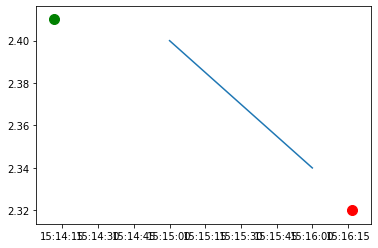

buy time:2020-02-24T15:14:11.433564013Z sell time:2020-02-24T15:16:16.569990868Z
{'rsi': 69.23142339858099, 'macd1': [0.029018262504794112, 0.036239216702846466, 0.038723562963966174, 0.0433876682914649, 0.052929201886610766], 'macd2': [0.02322205248825071, 0.025113838175687242, 0.026260796797874075, 0.02790738160493511, 0.030657146544810665], 'macd_signal': [0.017826868954113007, 0.0215093385038597, 0.024952183395880994, 0.028639280374997775, 0.03349726467732037]}
{'rsi': 54.669287082249596, 'macd': [0.02688036897113877, 0.033020887946991984, 0.0360262158769169, 0.03739106600572928, 0.0338183379761583], 'scalp': 0, 'bail_out': 0, 'movement': -0.04718685831622177, 'too_close': 0, 'macd_signal': [0.017386896105223024, 0.020513694473576816, 0.02361619875424483, 0.026371172204541722, 0.02786060535886504], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0059577326172932585}
APT analysis for ru

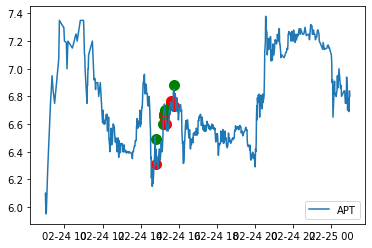

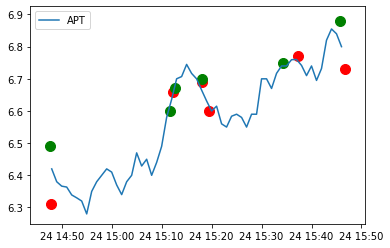

Delta = -0.33000000000000007


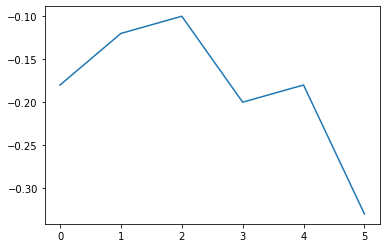

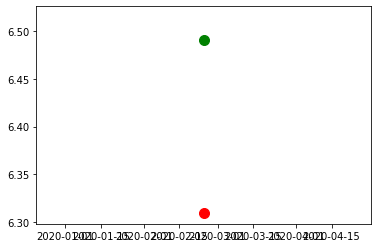

buy time:2020-02-24T14:47:41.408324222Z sell time:2020-02-24T14:47:53.195537417Z
{'rsi': 54.119577264472106, 'macd1': [0.134020334564533, 0.13704346323311523, 0.143912940529205, 0.15276038923093616, 0.15734502409148465], 'macd2': [0.07661392980342097, 0.08027606273543242, 0.08473246562452452, 0.08972057165623237, 0.09404474186508338], 'macd_signal': [0.13359606619428163, 0.13428554560204836, 0.1362110245874797, 0.13952089751617097, 0.14308572283123372]}
{'rsi': 41.97646977896559, 'macd': [0.0805071522164793, 0.08215447787925889, 0.08631921894273376, 0.09176811822670494, 0.08428196028919199], 'scalp': 0, 'bail_out': 0, 'movement': -0.03003506397637789, 'too_close': 1, 'macd_signal': [0.08195746518919392, 0.0819968677272069, 0.08286133797031228, 0.08464269402159082, 0.08457054727511105], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00028858698591906207}


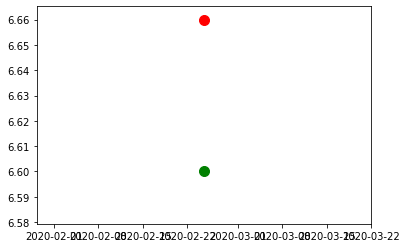

buy time:2020-02-24T15:11:45.718794269Z sell time:2020-02-24T15:12:15.022657036Z
{'rsi': 64.68523569629279, 'macd1': [0.059511820930290504, 0.05498431745095811, 0.054001409397907985, 0.056604528052664804, 0.06677387140835656], 'macd2': [0.09540872688559521, 0.0944090462876277, 0.09397805818643867, 0.09423091070399803, 0.0960721302162284], 'macd_signal': [0.06553466869228089, 0.06342459844401634, 0.061539960634794666, 0.060552874118368696, 0.06179707357636627]}
{'rsi': 67.47055342824201, 'macd': [0.028839122970715003, 0.028376710376125658, 0.030245262765068226, 0.03598380666859313, 0.04362444079252725], 'scalp': 0, 'bail_out': 1, 'movement': 0.0075757575757576835, 'too_close': 0, 'macd_signal': [0.033704374854940676, 0.03263884195917767, 0.03216012612035578, 0.03292486223000325, 0.03506477794250805], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008559662850019203}


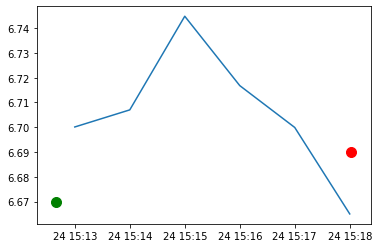

buy time:2020-02-24T15:12:39.843364092Z sell time:2020-02-24T15:18:01.671979101Z
{'rsi': 68.43860859657293, 'macd1': [0.05498431745095811, 0.054001409397907985, 0.056604528052664804, 0.06517842981291455, 0.078332587262536], 'macd2': [0.0944090462876277, 0.09397805818643867, 0.09423091070399803, 0.0957522581650494, 0.09843822836705662], 'macd_signal': [0.06342459844401634, 0.061539960634794666, 0.060552874118368696, 0.061477985257277865, 0.06484890565832949]}
{'rsi': 66.73487969729433, 'macd': [0.05711061589774946, 0.0630496849849358, 0.0654041584946281, 0.06551148644380778, 0.06474432008675546], 'scalp': 0, 'bail_out': 1, 'movement': 0.004482758620689728, 'too_close': 0, 'macd_signal': [0.04193960486900773, 0.04616162089219335, 0.0500101284126803, 0.053110400018905796, 0.05543718403247573], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009307136054279727}


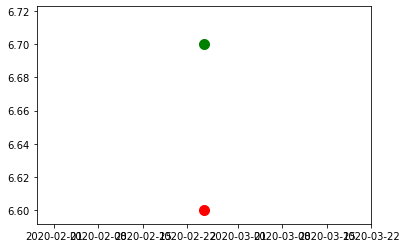

buy time:2020-02-24T15:18:10.673331904Z sell time:2020-02-24T15:19:29.938740728Z
{'rsi': 68.24308094687855, 'macd1': [0.09734055471063563, 0.10652326826252079, 0.11027014334433982, 0.11060094127631448, 0.11160198306032498], 'macd2': [0.10329562779590873, 0.10609180590873901, 0.10804687932496737, 0.10940251163741976, 0.1108762021229861], 'macd_signal': [0.0747127125056689, 0.08107482365703927, 0.08691388759449939, 0.09165129833086241, 0.09564143527675492]}
{'rsi': 55.68280512717809, 'macd': [0.0630496849849358, 0.0654041584946281, 0.06551148644380778, 0.0629313330737693, 0.056726910537715725], 'scalp': 0, 'bail_out': 0, 'movement': -0.01858736059479554, 'too_close': 0, 'macd_signal': [0.04616162089219335, 0.0500101284126803, 0.053110400018905796, 0.0550745866298785, 0.055405051411445944], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001321859126269781}


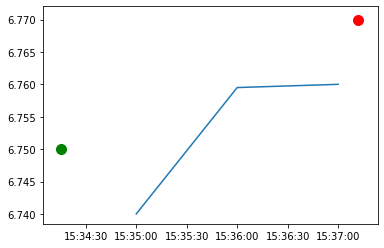

buy time:2020-02-24T15:34:15.578085191Z sell time:2020-02-24T15:37:11.756416227Z
{'rsi': 66.04929463154771, 'macd1': [0.041472628046355986, 0.04598907507622041, 0.046610347534647545, 0.05031521515837678, 0.05527697508969265], 'macd2': [0.09519260641348204, 0.09526635687143337, 0.09470203635014585, 0.09478308006670577, 0.09523383947155928], 'macd_signal': [0.05073596168215421, 0.04978658436096745, 0.04915133699570347, 0.04938411262823813, 0.050562685120529034]}
{'rsi': 67.99688208429131, 'macd': [0.024848656256691193, 0.02739378602394993, 0.030216045764360544, 0.03202279301968858, 0.03477061175085705], 'scalp': 0, 'bail_out': 1, 'movement': 0.0035259259259258664, 'too_close': 0, 'macd_signal': [0.025966998576393324, 0.026252356065904644, 0.027045094005595825, 0.028040633808414376, 0.02938662939690291], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005383982353954139}


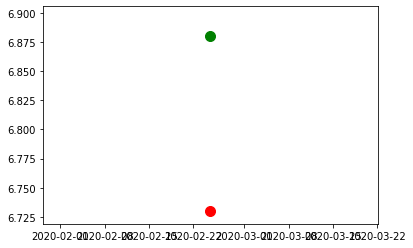

buy time:2020-02-24T15:45:40.821391141Z sell time:2020-02-24T15:46:40.475299013Z
{'rsi': 70.68861893746002, 'macd1': [0.050508939776438666, 0.04877659901803355, 0.05388343632677017, 0.06006248622590249, 0.06621345140355928], 'macd2': [0.09224053059442916, 0.09139669338582745, 0.09188159694818854, 0.09274054805142651, 0.09378232505916184], 'macd_signal': [0.0551294023792405, 0.05385884170699911, 0.05386376063095332, 0.05510350574994315, 0.05732549488066638]}
{'rsi': 53.00846630673847, 'macd': [0.02691525837448605, 0.03030394896427957, 0.034369111125622354, 0.03631119708088093, 0.03163865110990205], 'scalp': 0, 'bail_out': 0, 'movement': -0.021802325581395273, 'too_close': 1, 'macd_signal': [0.029976791660450235, 0.030042223121216103, 0.030907600722097354, 0.03198831999385407, 0.031918386217063666], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0002797351071616161}
CTSO analysis for run 7

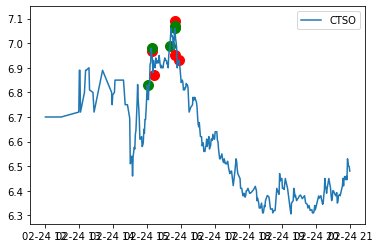

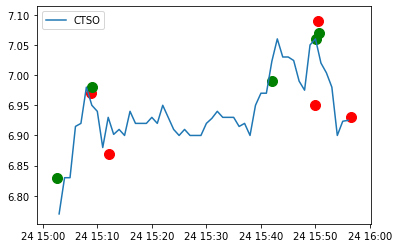

Delta = -0.120000000000001


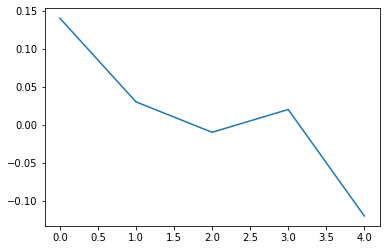

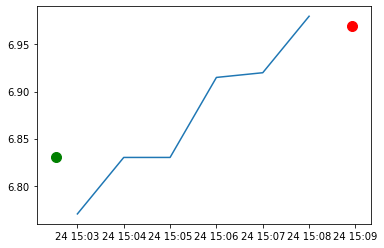

buy time:2020-02-24T15:02:31.784171503Z sell time:2020-02-24T15:08:55.456082874Z
{'rsi': 64.99017890257896, 'macd1': [0.0009777962002814888, 0.005726127647394996, 0.00938107533220034, 0.015328614682607267, 0.02779089064452034], 'macd2': [0.00879105239022504, 0.00956987581173152, 0.010271112592874942, 0.011539589755225066, 0.014287533614300685], 'macd_signal': [0.007006575744260948, 0.006750486124887758, 0.0072766039663502745, 0.008887006109601673, 0.012667783016585407]}
{'rsi': 71.26398105018981, 'macd': [0.027987743287445355, 0.030771739729784642, 0.03695703903901304, 0.041556531500242855, 0.04719825898301622], 'scalp': 1, 'bail_out': 0, 'movement': 0.020497803806734945, 'too_close': 0, 'macd_signal': [0.016222156978889953, 0.019132073529068892, 0.022697066631057722, 0.02646895960489475, 0.030614819480519043], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.016583439502497174}


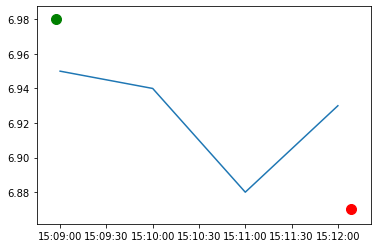

buy time:2020-02-24T15:08:57.571894268Z sell time:2020-02-24T15:12:08.803046191Z
{'rsi': 71.78151912778036, 'macd1': [0.04443309474815482, 0.0489330281987268, 0.05868160251813492, 0.06604949860863218, 0.07585569071818377], 'macd2': [0.019952166679250816, 0.021917891476151752, 0.025050822780335658, 0.027973122516362636, 0.03157660880286173], 'macd_signal': [0.025996173092340813, 0.03058354411361801, 0.036203155794521394, 0.04217242435734355, 0.04890907762951159]}
{'rsi': 57.969512583478135, 'macd': [0.047717739502497025, 0.050340528341883406, 0.051211006290212246, 0.04810733967475134, 0.04454464699160354], 'scalp': 0, 'bail_out': 0, 'movement': -0.01575931232091695, 'too_close': 0, 'macd_signal': [0.030718715584415204, 0.03464307813590885, 0.037956663766769524, 0.03998679894836589, 0.04089836855701342], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0036462784345901236}


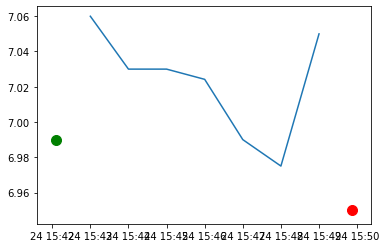

buy time:2020-02-24T15:42:05.230152972Z sell time:2020-02-24T15:49:51.549903853Z
{'rsi': 65.79808312883964, 'macd1': [0.018377583877917658, 0.019586664771058082, 0.02190618211159645, 0.023473824676274013, 0.026029968284767335], 'macd2': [0.042922285304024754, 0.0428267314968247, 0.04299019561663453, 0.04307183102535728, 0.043397922889159446], 'macd_signal': [0.026784970592682113, 0.025345309428357308, 0.024657483965005136, 0.02442075210725891, 0.024742595342760597]}
{'rsi': 49.33950976723283, 'macd': [0.022810237775344078, 0.02297539957053374, 0.021029091884051887, 0.018460162623363807, 0.014919955892653824], 'scalp': 0, 'bail_out': 0, 'movement': -0.016277423920736053, 'too_close': 1, 'macd_signal': [0.01742137396365877, 0.018532179085033764, 0.019031561644837387, 0.01891728184054267, 0.018117816650964902], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0031978607583110774}


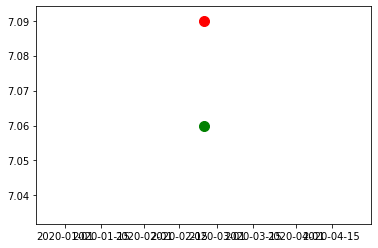

buy time:2020-02-24T15:50:06.721737457Z sell time:2020-02-24T15:50:28.128478291Z
{'rsi': 65.48493011404432, 'macd1': [0.039531656038548135, 0.036552959523813655, 0.032606083798323304, 0.035125128927374405, 0.03749617421164686], 'macd2': [0.04672209228662805, 0.0463913685988544, 0.04577299167763815, 0.04633037781820981, 0.04692902795742704], 'macd_signal': [0.03299525350208212, 0.03370679470642843, 0.033486652524807405, 0.033814347805320805, 0.03455071308658601]}
{'rsi': 68.43626528118992, 'macd': [0.02297539957053374, 0.021029091884051887, 0.018460162623363807, 0.020114761087459243, 0.023220750006397672], 'scalp': 0, 'bail_out': 1, 'movement': 0.004249291784702585, 'too_close': 0, 'macd_signal': [0.018532179085033764, 0.019031561644837387, 0.01891728184054267, 0.019156777689925984, 0.019969572153220323], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003251177853177349}


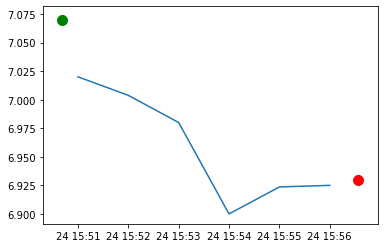

buy time:2020-02-24T15:50:41.360590071Z sell time:2020-02-24T15:56:33.77268243Z
{'rsi': 67.50067825195597, 'macd1': [0.039531656038548135, 0.036552959523813655, 0.032606083798323304, 0.035125128927374405, 0.039083638599111126], 'macd2': [0.04672209228662805, 0.0463913685988544, 0.04577299167763815, 0.04633037781820981, 0.047247300648350254], 'macd_signal': [0.03299525350208212, 0.03370679470642843, 0.033486652524807405, 0.033814347805320805, 0.03486820596407887]}
{'rsi': 44.99771215211395, 'macd': [0.02050893874901938, 0.018502300818042272, 0.015462033588475421, 0.00873634440194948, 0.0049405301734619655], 'scalp': 0, 'bail_out': 0, 'movement': -0.004310344827586242, 'too_close': 1, 'macd_signal': [0.01982809482302949, 0.019562936022032046, 0.01874275553532072, 0.016741473308646473, 0.014381284681609572], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009440754508147606}
VHC analysis for

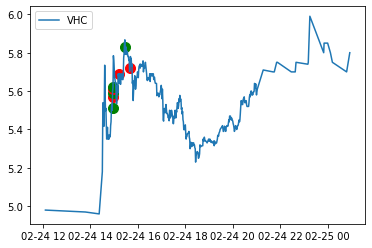

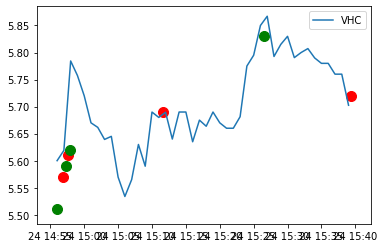

Delta = 0.040000000000000924


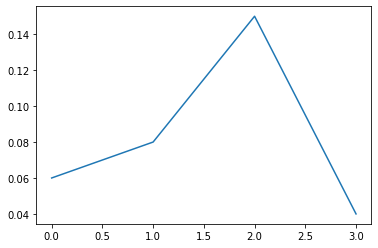

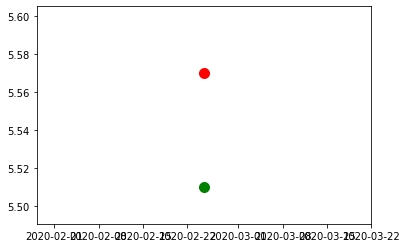

buy time:2020-02-24T14:55:55.388456536Z sell time:2020-02-24T14:56:54.658661579Z
{'rsi': 63.90331598227695, 'macd1': [0.05036009942857955, 0.05117713288498127, 0.05722492681367264, 0.062499694970753694, 0.06592010084914168], 'macd2': [0.06474534806569743, 0.06530891687564644, 0.06692408527396321, 0.06854136082111673, 0.06991968372823987], 'macd_signal': [0.07111302377019554, 0.06712584559315268, 0.06514566183725667, 0.06461646846395608, 0.0648771949409932]}
{'rsi': 63.94213485948262, 'macd': [0.027050008418203042, 0.031097483665837977, 0.03462152303197108, 0.035359456005166656, 0.038072657594601544], 'scalp': 0, 'bail_out': 1, 'movement': 0.0036166365280288558, 'too_close': 0, 'macd_signal': [0.03758929225567824, 0.03629093053771019, 0.03595704903656237, 0.035837530430283225, 0.03628455586314689], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001788101731454654}


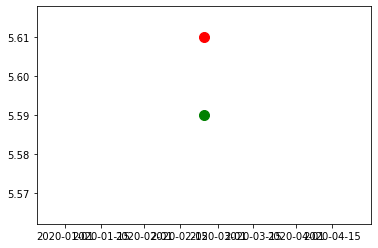

buy time:2020-02-24T14:57:14.404684143Z sell time:2020-02-24T14:57:39.642076997Z
{'rsi': 65.55258027111243, 'macd1': [0.05722492681367264, 0.062499694970753694, 0.06352693845597912, 0.07158501311299581, 0.07629279225324659], 'macd2': [0.06692408527396321, 0.06854136082111673, 0.06943987565147136, 0.07175483891498136, 0.07361158066375229], 'macd_signal': [0.06514566183725667, 0.06461646846395608, 0.06439856246236068, 0.06583585259248771, 0.06792724052463948]}
{'rsi': 67.08908922200986, 'macd': [0.031097483665837977, 0.03462152303197108, 0.035359456005166656, 0.0406700601920047, 0.04479949124419047], 'scalp': 0, 'bail_out': 1, 'movement': 0.003559864760916745, 'too_close': 0, 'macd_signal': [0.03629093053771019, 0.03595704903656237, 0.035837530430283225, 0.03680403638262752, 0.03840312735494011], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006396363889250363}


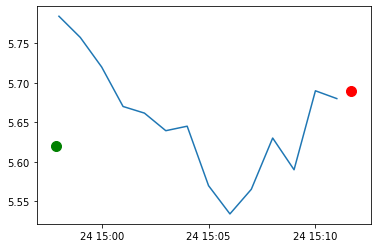

buy time:2020-02-24T14:57:52.763303084Z sell time:2020-02-24T15:11:41.206422617Z
{'rsi': 68.1291703200747, 'macd1': [0.05722492681367264, 0.062499694970753694, 0.06352693845597912, 0.07158501311299581, 0.07956344752390176], 'macd2': [0.06692408527396321, 0.06854136082111673, 0.06943987565147136, 0.07175483891498136, 0.07426731836867084], 'macd_signal': [0.06514566183725667, 0.06461646846395608, 0.06439856246236068, 0.06583585259248771, 0.06858137157877052]}
{'rsi': 60.841711750337105, 'macd': [0.03441007178365574, 0.03322719891981141, 0.029785646052921777, 0.031917089974138335, 0.03312188926373416], 'scalp': 0, 'bail_out': 1, 'movement': 0.0033686067019400166, 'too_close': 0, 'macd_signal': [0.04790019182451512, 0.044965593243574374, 0.04192960380544385, 0.03992710103918275, 0.03856605868409303], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005444169420358871}


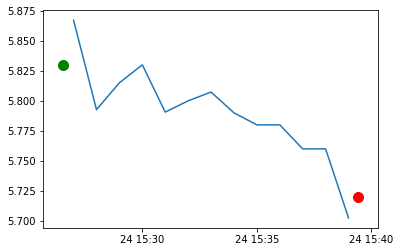

buy time:2020-02-24T15:26:31.462288736Z sell time:2020-02-24T15:39:24.208513661Z
{'rsi': 68.95271762995128, 'macd1': [0.03720794498428237, 0.03609056215963857, 0.04227847519264216, 0.048240190814595074, 0.055815435922226264], 'macd2': [0.07941393340661929, 0.07861778403980235, 0.07925816355631454, 0.08004044288988865, 0.08132467438728685], 'macd_signal': [0.046971770802994486, 0.044795529074323305, 0.04429211829798708, 0.04508173280130868, 0.0472284734254922]}
{'rsi': 47.647883383867295, 'macd': [0.02707256595045493, 0.024582547074977867, 0.021284057729476835, 0.018437389957274952, 0.013953786628841058], 'scalp': 0, 'bail_out': 0, 'movement': -0.02009146498124457, 'too_close': 1, 'macd_signal': [0.03122873983033019, 0.029899501279259725, 0.028176412569303148, 0.026228608046897507, 0.023773643763286216], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009819857134445158}
AHPI analysis for 

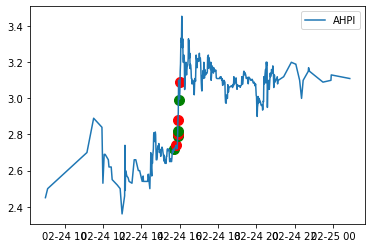

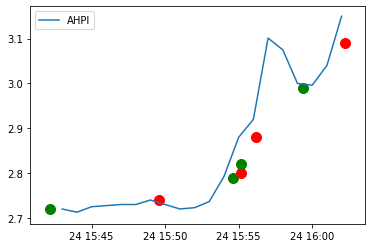

Delta = 0.1899999999999995


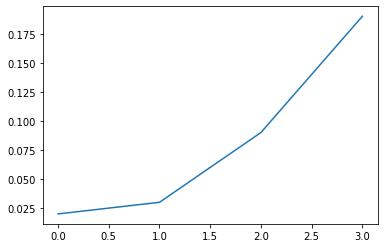

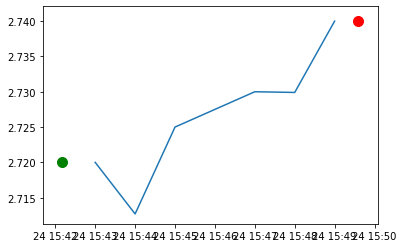

buy time:2020-02-24T15:42:10.218356974Z sell time:2020-02-24T15:49:35.137319152Z
{'rsi': 58.15074853035661, 'macd1': [-0.0013173795492771312, 0.0011934024299877777, 0.0023492184829159157, 0.0040257214476557834, 0.006091064551680958], 'macd2': [0.018055092194020794, 0.018000044116883274, 0.017760673544327865, 0.017671975270986184, 0.017722042192999776], 'macd_signal': [-0.004015172296344528, -0.0029734573510780665, -0.00190892218427927, -0.0007219934578922592, 0.0006406181440223844]}
{'rsi': 62.5041832971993, 'macd': [0.005185206705758283, 0.006019102659016173, 0.00685046180884008, 0.007404112291705456, 0.008264046274565118], 'scalp': 0, 'bail_out': 1, 'movement': 0.007352941176470594, 'too_close': 0, 'macd_signal': [0.0019149729497366314, 0.0027357988915925396, 0.0035587314750420477, 0.004327807638374729, 0.005115055365612807], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00314899090895

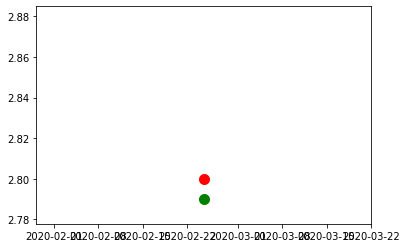

buy time:2020-02-24T15:54:38.852160557Z sell time:2020-02-24T15:55:07.535579894Z
{'rsi': 70.24338757153068, 'macd1': [0.01310092989529199, 0.01243713476086894, 0.011998695441752805, 0.012611329075587818, 0.017215400109782397], 'macd2': [0.01800683994169372, 0.017831299228990627, 0.017686059574113955, 0.017743260420108875, 0.0186231668994985], 'macd_signal': [0.008191930183717123, 0.009040971099147487, 0.00963251596766855, 0.010228278589252404, 0.011625702893358403]}
{'rsi': 71.63905128320424, 'macd': [0.008264046274565118, 0.00778783838751318, 0.007461081093868671, 0.007821256175524205, 0.011299038626482627], 'scalp': 0, 'bail_out': 1, 'movement': 0.0035842293906809273, 'too_close': 0, 'macd_signal': [0.005115055365612807, 0.005649611969992882, 0.006011905794768039, 0.006373775870919272, 0.007358828422031944], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003940210204450683}


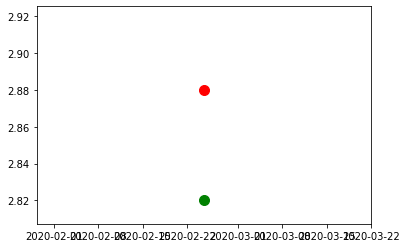

buy time:2020-02-24T15:55:11.10796167Z sell time:2020-02-24T15:56:12.018082806Z
{'rsi': 74.30606043553438, 'macd1': [0.01243713476086894, 0.011998695441752805, 0.012611329075587818, 0.017398875893258392, 0.023161211708889073], 'macd2': [0.017831299228990627, 0.017686059574113955, 0.017743260420108875, 0.018659952185383855, 0.01991651673682604], 'macd_signal': [0.009040971099147487, 0.00963251596766855, 0.010228278589252404, 0.011662398050053601, 0.013962160781820696]}
{'rsi': 80.40384100903744, 'macd': [0.00778783838751318, 0.007461081093868671, 0.007821256175524205, 0.010899038626482671, 0.018127193281431087], 'scalp': 1, 'bail_out': 0, 'movement': 0.02411347517730499, 'too_close': 0, 'macd_signal': [0.005649611969992882, 0.006011905794768039, 0.006373775870919272, 0.007278828422031952, 0.00944850139391178], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008678691887519307}


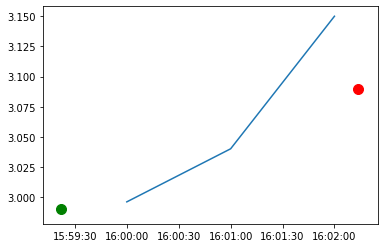

buy time:2020-02-24T15:59:22.236365156Z sell time:2020-02-24T16:02:13.529333204Z
{'rsi': 72.9470521563746, 'macd1': [0.027947536495213754, 0.03908454937144423, 0.06182739935286197, 0.07684328011490837, 0.08254696697844999], 'macd2': [0.02087613289036483, 0.023521445673491126, 0.02881723892870136, 0.03322281722719156, 0.036183370764143685], 'macd_signal': [0.014919425739085631, 0.01975245046555735, 0.028167440243018274, 0.03790260821739629, 0.04683147996960703]}
{'rsi': 76.26300378760983, 'macd': [0.04909234738169044, 0.05200234811353921, 0.05339192857844033, 0.056067031166954884, 0.060015591220771825], 'scalp': 1, 'bail_out': 0, 'movement': 0.02657807308970102, 'too_close': 0, 'macd_signal': [0.02412299366180854, 0.029698864552154675, 0.0344374773574118, 0.03876338811932042, 0.043013828739610696], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.01700176248116113}
CBLI analysis for run 70
2

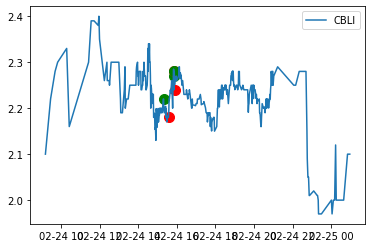

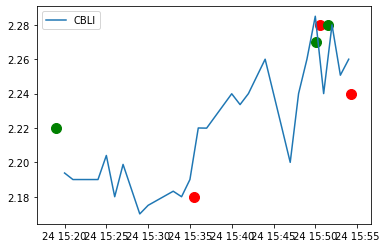

Delta = -0.06999999999999984


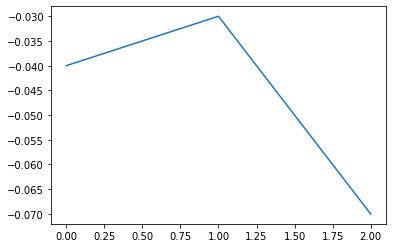

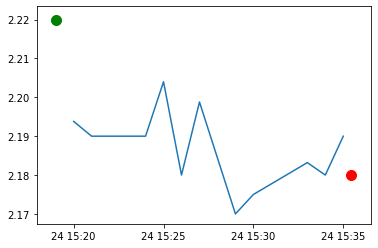

buy time:2020-02-24T15:19:01.863871479Z sell time:2020-02-24T15:35:26.987879947Z
{'rsi': 55.057694921136736, 'macd1': [0.003945106912794483, 0.003712221350859579, 0.00365497800346537, 0.005794118081678068, 0.007404052694731433], 'macd2': [0.019402397864032306, 0.019016057846133805, 0.018663785709960745, 0.018756055470786848, 0.01881094891252122], 'macd_signal': [0.0029972389410916934, 0.0031402354230452706, 0.0032431839391292906, 0.003753370767639046, 0.0044835071530575235]}
{'rsi': 48.87048168351713, 'macd': [0.0010126555014204897, -0.00032177065630412116, -0.0010976641473061655, -0.001262027073446692, -0.0010776082227321737], 'scalp': 0, 'bail_out': 1, 'movement': 0.004082568807339305, 'too_close': 0, 'macd_signal': [0.0015684311108983564, 0.001190390757457861, 0.0007327797765050556, 0.000333818406514706, 5.153308066533003e-05], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011291413

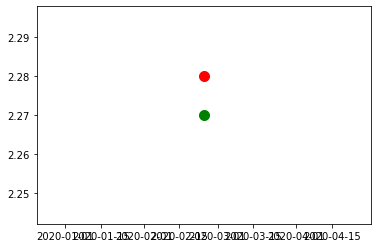

buy time:2020-02-24T15:50:05.608197563Z sell time:2020-02-24T15:50:34.526043855Z
{'rsi': 62.040041405009006, 'macd1': [0.012709176484200224, 0.010179206724339807, 0.011271917519613428, 0.013595016660985948, 0.016057900413787962], 'macd2': [0.014690416727195732, 0.014237643031699942, 0.014438049730835623, 0.014919210712757813, 0.015497969040047632], 'macd_signal': [0.007967253965517684, 0.008409644517282109, 0.008982099117748372, 0.009904682626395888, 0.011135326183874302]}
{'rsi': 63.6080285050433, 'macd': [0.007881965274385117, 0.0062023425348849415, 0.006890917769886595, 0.008376938501447828, 0.010465046363684394], 'scalp': 0, 'bail_out': 1, 'movement': 0.004405286343612241, 'too_close': 0, 'macd_signal': [0.004793989267096313, 0.005075659920654039, 0.0054387114905005505, 0.006026356892690006, 0.006914094786888884], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00355095157679551}


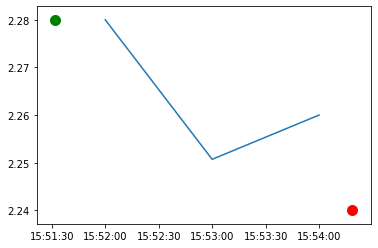

buy time:2020-02-24T15:51:31.981253865Z sell time:2020-02-24T15:54:18.360276342Z
{'rsi': 63.6080285050433, 'macd1': [0.012709176484200224, 0.010179206724339807, 0.011271917519613428, 0.013595016660985948, 0.01685562121150852], 'macd2': [0.014690416727195732, 0.014237643031699942, 0.014438049730835623, 0.014919210712757813, 0.015657905065637134], 'macd_signal': [0.007967253965517684, 0.008409644517282109, 0.008982099117748372, 0.009904682626395888, 0.011294870343418414]}
{'rsi': 52.520568940202, 'macd': [0.010724786623424798, 0.010077333385699827, 0.011519871987658359, 0.010972241391942195, 0.009919902727852037], 'scalp': 0, 'bail_out': 0, 'movement': -0.0169298245614034, 'too_close': 1, 'macd_signal': [0.006966042838836965, 0.007588300948209537, 0.008374615156099302, 0.008894140403267881, 0.009099292868184712], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008206098596673251}
BIMI analy

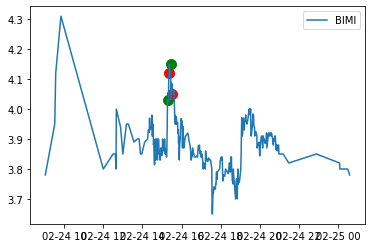

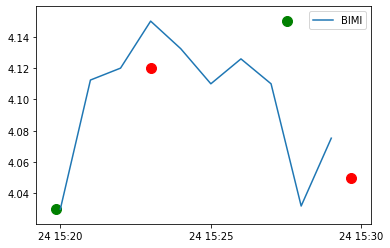

Delta = -0.010000000000000675


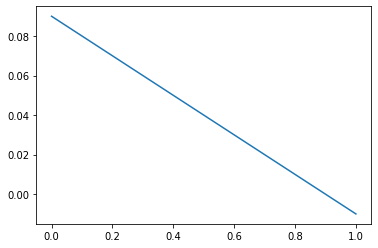

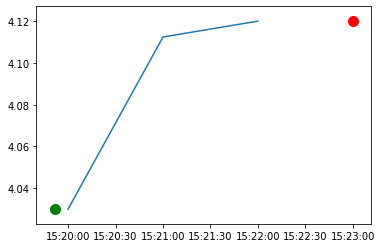

buy time:2020-02-24T15:19:51.613483452Z sell time:2020-02-24T15:22:59.823596889Z
{'rsi': 70.56608778273849, 'macd1': [0.0033300253543120384, 0.0031613424981893345, 0.00857720245423943, 0.020699859656794217, 0.029961772169829537], 'macd2': [0.0319472087411623, 0.031228026325340608, 0.0316359628131031, 0.03356004038491012, 0.03527657870205836], 'macd_signal': [0.00883980438112442, 0.0077041120045374025, 0.007878730094477808, 0.01044295600694109, 0.014346719239518779]}
{'rsi': 76.83971421162946, 'macd': [0.012130560101705434, 0.018172323974586124, 0.022348083823914067, 0.025607791708794014, 0.03249057977871628], 'scalp': 1, 'bail_out': 0, 'movement': 0.02233250620347391, 'too_close': 0, 'macd_signal': [0.005134018798526162, 0.0077416798337381545, 0.010662960631773338, 0.013651926847177472, 0.017419657433485232], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.015070922345231046}


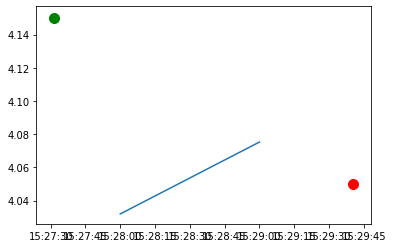

buy time:2020-02-24T15:27:31.403413756Z sell time:2020-02-24T15:29:40.199168044Z
{'rsi': 73.54155192829883, 'macd1': [0.06747472618385464, 0.07151187914701573, 0.0720730459512362, 0.07295973736820338, 0.07474549574482259], 'macd2': [0.045490638054708654, 0.047508604336801596, 0.04893095779451828, 0.05041560852423732, 0.05208634778652721], 'macd_signal': [0.04156685267507824, 0.04755585796946574, 0.05245929556581983, 0.056559383926296544, 0.06019660629000175]}
{'rsi': 54.33979616110955, 'macd': [0.04456133579291599, 0.044715234345923616, 0.045080411993124514, 0.04395353208194219, 0.038348774591645096], 'scalp': 0, 'bail_out': 0, 'movement': -0.02891566265060243, 'too_close': 0, 'macd_signal': [0.029283706668385107, 0.03237001220389281, 0.03491209216173915, 0.03672038014577976, 0.037046059034952825], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0013027155566922716}
TECS analysis for run 7

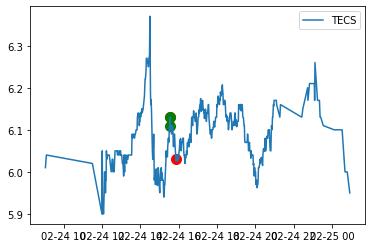

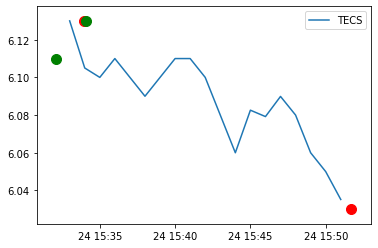

Delta = -0.08000000000000007


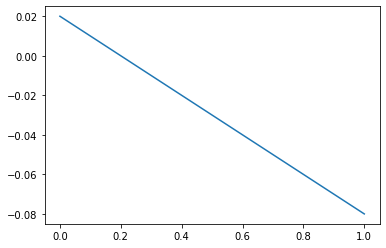

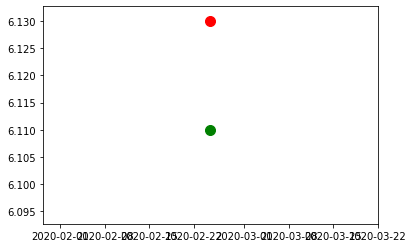

buy time:2020-02-24T15:32:06.496006892Z sell time:2020-02-24T15:33:58.345430471Z
{'rsi': 71.06423717848872, 'macd1': [0.024815889099679467, 0.025590208665875913, 0.026455670335506554, 0.02916159420390141, 0.031260405277955705], 'macd2': [0.04307085250301412, 0.04297432097558129, 0.04292713331923359, 0.043282076409783876, 0.043601786823905364], 'macd_signal': [0.017530402324628706, 0.01914236359287815, 0.02060502494140383, 0.022316338793903344, 0.024105152090713816]}
{'rsi': 74.10719439866617, 'macd': [0.015234921573918037, 0.01577581336026057, 0.017509289903380854, 0.018840449678495297, 0.020666802104837956], 'scalp': 0, 'bail_out': 1, 'movement': 0.0032733224222585224, 'too_close': 0, 'macd_signal': [0.010882934276387205, 0.011861510093161878, 0.012991066055205672, 0.014160942779863597, 0.015462114644858468], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005204687459979488}


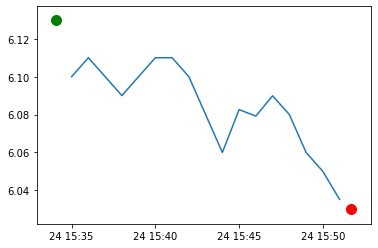

buy time:2020-02-24T15:34:04.690656906Z sell time:2020-02-24T15:51:42.433596465Z
{'rsi': 74.10719439866615, 'macd1': [0.026455670335506554, 0.02916159420390141, 0.031268382485932555, 0.03415012963013453, 0.036018733465277286], 'macd2': [0.04292713331923359, 0.043282076409783876, 0.043603386184160264, 0.0441475366224271, 0.04457756461601381], 'macd_signal': [0.02060502494140383, 0.022316338793903344, 0.024106747532309188, 0.026115423951874255, 0.02809608585455486]}
{'rsi': 39.65125906599161, 'macd': [0.006609687909406858, 0.005654724205524708, 0.003798197628402278, 0.00178274578092541, -0.0005797198895880484], 'scalp': 0, 'bail_out': 0, 'movement': -0.015464926590538372, 'too_close': 1, 'macd_signal': [0.010811267665946426, 0.009779958973862083, 0.008583606704770121, 0.007223434520001179, 0.005662803638083334], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006242523527671382}
EGO analysi

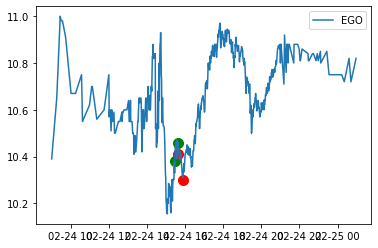

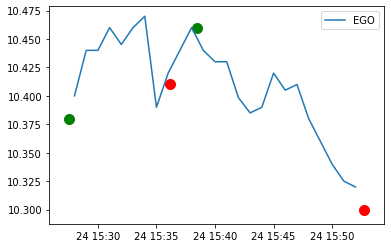

Delta = -0.13000000000000078


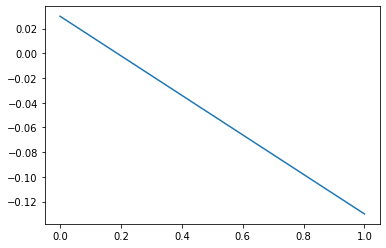

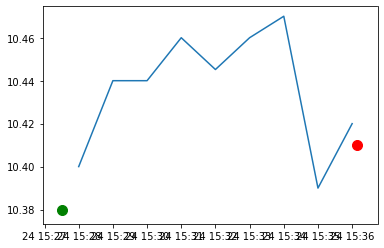

buy time:2020-02-24T15:27:31.394134668Z sell time:2020-02-24T15:36:09.311539841Z
{'rsi': 56.82993084871393, 'macd1': [-0.018701836514996018, -0.014744181434373616, -0.010677708861983604, -0.0017859972014271364, 0.005208774010705852], 'macd2': [0.03249179359011478, 0.0315659706771072, 0.0308236346493036, 0.0312109158413989, 0.03151890878807784], 'macd_signal': [-0.03416568880349323, -0.030281387329669306, -0.026360651636132167, -0.021445720749191162, -0.01611482179721176]}
{'rsi': 54.72207191855317, 'macd': [0.024541156082978688, 0.026763066136727076, 0.028666332852157694, 0.02562126363233652, 0.02421444003724993], 'scalp': 0, 'bail_out': 1, 'movement': 0.00336220267627466, 'too_close': 0, 'macd_signal': [0.009614143610623101, 0.013043928115843897, 0.016168409063106657, 0.01805897997695263, 0.01929007198901209], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004924368048237839}


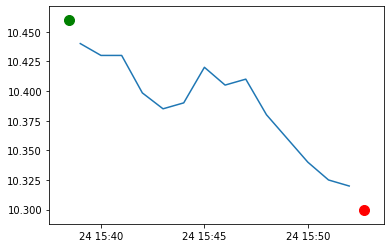

buy time:2020-02-24T15:38:26.417077503Z sell time:2020-02-24T15:52:42.825432248Z
{'rsi': 58.831232211237094, 'macd1': [0.04319056376894892, 0.03889081478329004, 0.03747202780269454, 0.03752885250105642, 0.038741135640787405], 'macd2': [0.0373886016295355, 0.03692575451868585, 0.0369206708640899, 0.03717681633682979, 0.03767289129381801], 'macd_signal': [0.023188489993121987, 0.026328954951155597, 0.028557569521463384, 0.03035182611738199, 0.032029688022063074]}
{'rsi': 37.223865688308116, 'macd': [0.006780622758292054, 0.0037781351566064103, 0.0003505066987141703, -0.003104145433393768, -0.007054469881355274], 'scalp': 0, 'bail_out': 0, 'movement': -0.015296367112810719, 'too_close': 1, 'macd_signal': [0.012735865863744042, 0.010944319722316517, 0.008825557117596047, 0.006439616607398084, 0.003740799309647412], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.010795269191002686}
HMY analys

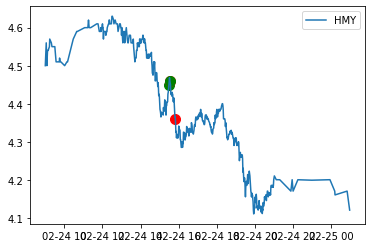

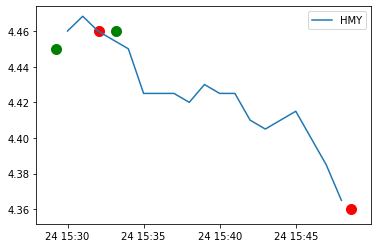

Delta = -0.08999999999999986


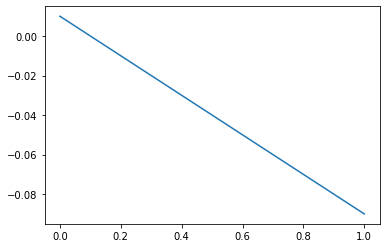

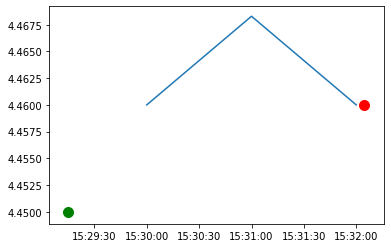

buy time:2020-02-24T15:29:14.729387177Z sell time:2020-02-24T15:32:04.364741606Z
{'rsi': 66.39467001462668, 'macd1': [-0.00011111243011008298, 0.002243185155877292, 0.0044131540889909004, 0.006860700642411288, 0.00949783027096096], 'macd2': [0.02135412118152402, 0.021222911544199086, 0.021138623250852362, 0.021187203076523886, 0.021357948125130477], 'macd_signal': [-0.003153090120720484, -0.0020738350654009286, -0.0007764372345225627, 0.0007509903408642075, 0.002500358326883558]}
{'rsi': 69.12617097204947, 'macd': [0.004351815012503479, 0.006058903793319637, 0.007829896300536099, 0.009539372328229767, 0.010576115046845302], 'scalp': 0, 'bail_out': 1, 'movement': 0.0033707865168538607, 'too_close': 0, 'macd_signal': [0.00018578300426131365, 0.0013604071620729784, 0.0026543049897656025, 0.004031318457458436, 0.005340277775335809], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0052358372715

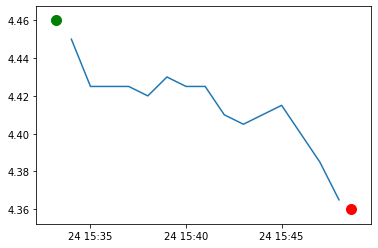

buy time:2020-02-24T15:33:11.546848612Z sell time:2020-02-24T15:48:38.409233016Z
{'rsi': 66.37625582923839, 'macd1': [0.00949783027096096, 0.012253440888531308, 0.014934862986189401, 0.016203386134083786, 0.017012589328199823], 'macd2': [0.021357948125130477, 0.0216408160037167, 0.021999198940386044, 0.022160991160104615, 0.022274401769033503], 'macd_signal': [0.002500358326883558, 0.004450974839213108, 0.006547752468608366, 0.00847887920170345, 0.010185621227002725]}
{'rsi': 28.55237432606177, 'macd': [-0.0002653038150910447, -0.0005876589237177043, -0.0016104335677944448, -0.0031657068804804567, -0.0056351963854242015], 'scalp': 0, 'bail_out': 0, 'movement': -0.006833712984054525, 'too_close': 1, 'macd_signal': [0.0029142980254965234, 0.002213906635653678, 0.0014490385949640534, 0.0005260894998751513, -0.0007061676771847194], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0049290287082

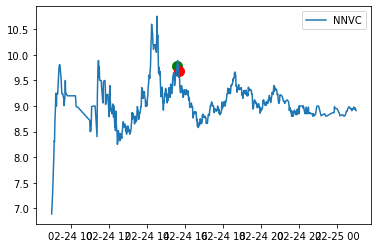

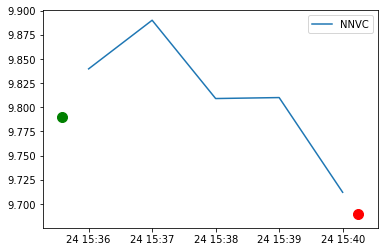

Delta = -0.09999999999999964


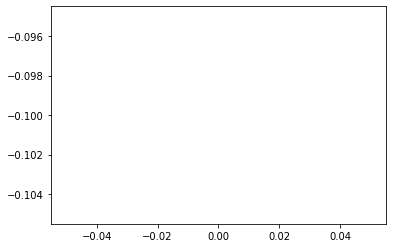

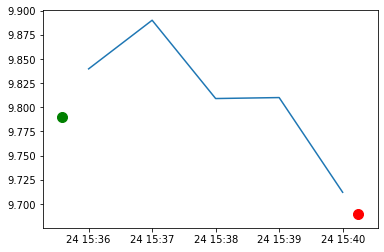

buy time:2020-02-24T15:35:35.165462998Z sell time:2020-02-24T15:40:14.368301104Z
{'rsi': 66.52484274015697, 'macd1': [0.09456543912958182, 0.09550621651808022, 0.09576914790202373, 0.10605185314127397, 0.11848358114192514], 'macd2': [0.23800053817365274, 0.23535848424958417, 0.23267443786162723, 0.23207200343934176, 0.23226612994096563], 'macd_signal': [0.09632776349551511, 0.09616345410002813, 0.09608459286042725, 0.0980780449165966, 0.1021591521616623]}
{'rsi': 53.6561362897276, 'macd': [0.07434505445600337, 0.0812258957812606, 0.08132491634923689, 0.08039785554052514, 0.07083913470853531], 'scalp': 0, 'bail_out': 0, 'movement': -0.01629327902240327, 'too_close': 1, 'macd_signal': [0.06070174221257093, 0.06480657292630887, 0.06811024161089448, 0.07056776439682061, 0.07062203845916355], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0002170962493717593}
UVXY analysis for run 70
2020-02-2

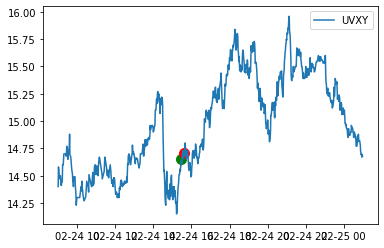

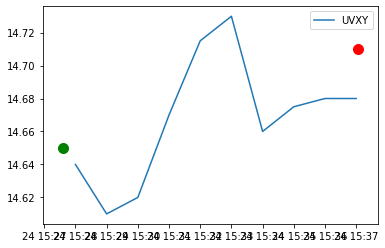

Delta = 0.0600000000000005


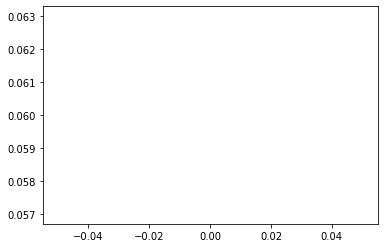

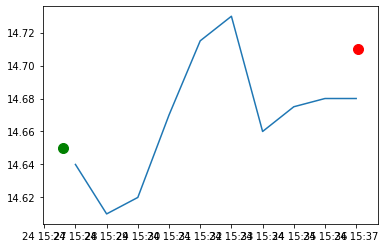

buy time:2020-02-24T15:27:35.408855867Z sell time:2020-02-24T15:37:02.543282284Z
{'rsi': 68.94677515519436, 'macd1': [0.06445247158772105, 0.07181919717792873, 0.0751769542964329, 0.08093158503832143, 0.08931220359634295], 'macd2': [0.17737688747701874, 0.17661123833279468, 0.17530447958261774, 0.17461992548326322, 0.17467204915997314], 'macd_signal': [0.045448186645126676, 0.05072238875168709, 0.05561330186063625, 0.060676958496173286, 0.06640400751620722]}
{'rsi': 66.2663330364083, 'macd': [0.061753028028201484, 0.059364292096786286, 0.05751119536975047, 0.055580065512710775, 0.05465217126680244], 'scalp': 0, 'bail_out': 1, 'movement': 0.003754266211604076, 'too_close': 1, 'macd_signal': [0.05130663883516832, 0.05291816948749191, 0.05383677466394362, 0.05418543283369705, 0.05427878052031813], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003733907464843131}
FNGD analysis for run 70
20

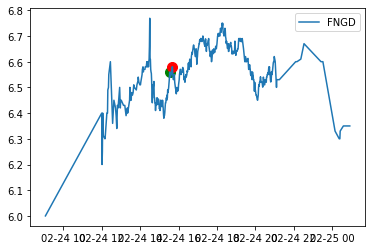

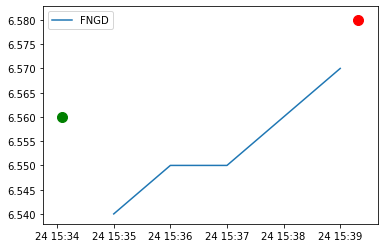

Delta = 0.020000000000000462


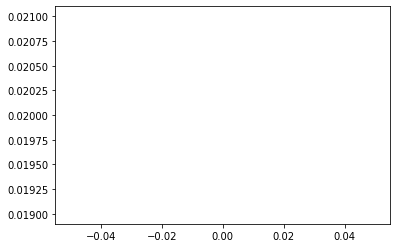

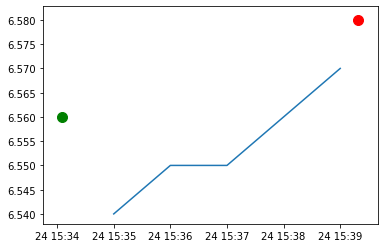

buy time:2020-02-24T15:34:05.059664838Z sell time:2020-02-24T15:39:18.723134464Z
{'rsi': 73.82301119911105, 'macd1': [0.02071787392462099, 0.023126064288060633, 0.025945859424224338, 0.029821814480487596, 0.032949450898009935], 'macd2': [0.0554131389517325, 0.05516922441551486, 0.05509648381355703, 0.05533488362948624, 0.05555208412606216], 'macd_signal': [0.01517451521805326, 0.016764825032054734, 0.018601031910488654, 0.02084518842448844, 0.02326604091919274]}
{'rsi': 73.57519980406457, 'macd': [0.019975424533546615, 0.020200799294065597, 0.02011406794779358, 0.020304743938389436, 0.021228585698096047], 'scalp': 0, 'bail_out': 1, 'movement': 0.003048780487804949, 'too_close': 0, 'macd_signal': [0.01568175342205549, 0.016585562596457513, 0.017291263666724725, 0.017893959721057666, 0.01856088491646534], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0026677007816307066}
GSS analysis for r

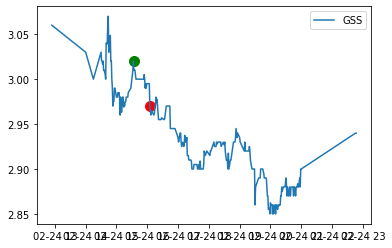

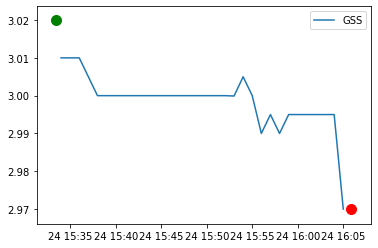

Delta = -0.04999999999999982


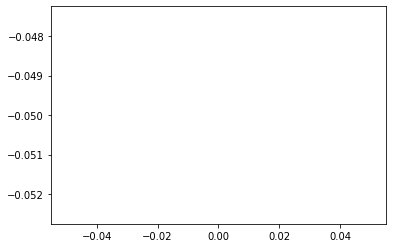

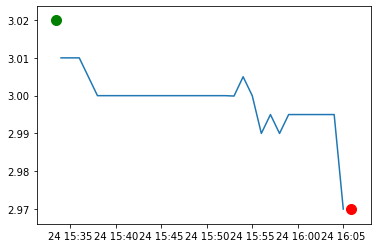

buy time:2020-02-24T15:33:29.576326839Z sell time:2020-02-24T16:05:53.38512986Z
{'rsi': 68.61699871861234, 'macd1': [-0.002035887875157183, -0.0009793517005465269, 0.0006573003074876738, 0.002729807717685606, 0.005120178962510824], 'macd2': [0.0038983750127901118, 0.003927041315165969, 0.004107070502093801, 0.004426070452958175, 0.004872417756088154], 'macd_signal': [-0.003793950442069062, -0.0032310306937645547, -0.002453364493514109, -0.0014167300512741658, -0.00010934824851716778]}
{'rsi': 29.153828043586827, 'macd': [-7.561307558212604e-05, -0.0001541121524932798, -0.00021327880784660636, -0.00025661284048705824, -0.0015857482835772707], 'scalp': 0, 'bail_out': 0, 'movement': -0.01655629139072842, 'too_close': 1, 'macd_signal': [0.0008579919572675708, 0.0006555711353154007, 0.00048180114668299926, 0.00033411834924898775, -4.9854977316263996e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

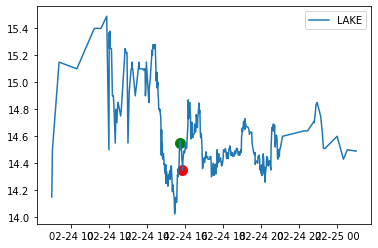

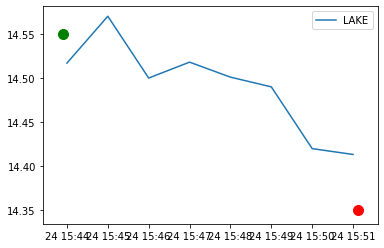

Delta = -0.20000000000000107


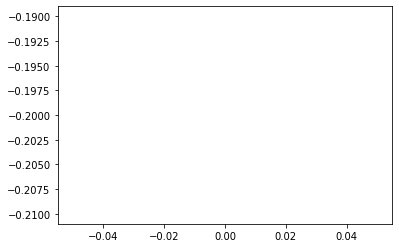

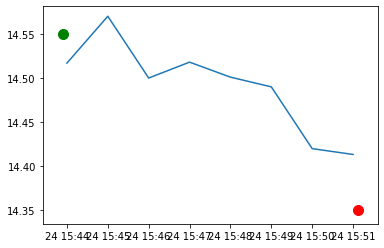

buy time:2020-02-24T15:43:53.85858222Z sell time:2020-02-24T15:51:06.615169762Z
{'rsi': 73.15098681983044, 'macd1': [0.003953137200278789, 0.01330815552211817, 0.02303863249196958, 0.03855238359379598, 0.056713272535752424], 'macd2': [0.013966840536919989, 0.015331625758237877, 0.017074546306504956, 0.020285326792846448, 0.024499187085490703], 'macd_signal': [-0.028136483197534444, -0.01984755545360392, -0.01127031786448922, -0.0013057775728321803, 0.01029803244888474]}
{'rsi': 47.58409983719142, 'macd': [0.052068953355286496, 0.05128150228862616, 0.04943048194722088, 0.04370981048707279, 0.03504812090140952], 'scalp': 0, 'bail_out': 0, 'movement': -0.015437392795883338, 'too_close': 1, 'macd_signal': [0.033116132449421715, 0.036749206417262606, 0.03928546152325426, 0.040170331316017965, 0.039145889233096275], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004097768331686756}
VIR analysi

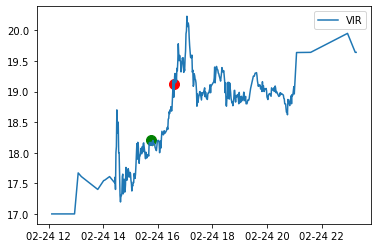

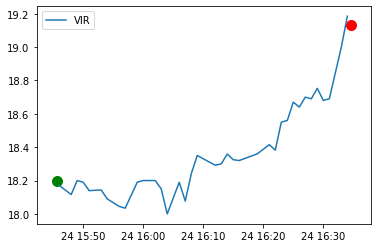

Delta = 0.9299999999999997


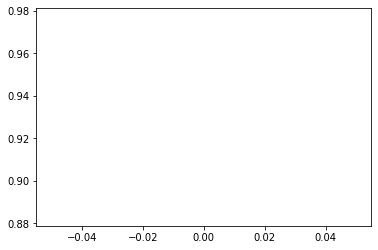

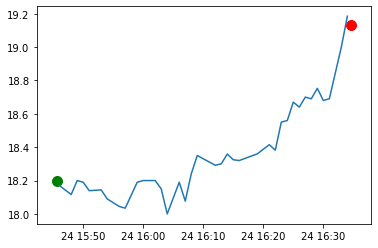

buy time:2020-02-24T15:45:33.52883902Z sell time:2020-02-24T16:34:39.634946729Z
{'rsi': 60.718270527464725, 'macd1': [0.03168131934119245, 0.044396013075889584, 0.05452181571046921, 0.05788508768103284, 0.06625819150206169], 'macd2': [0.1410896030346258, 0.14125983290453803, 0.14132487072902933, 0.14036699489985693, 0.1405439080295956], 'macd_signal': [0.0567401070983765, 0.054271288293879116, 0.054321393777197136, 0.05503413255796428, 0.05727894434678376]}
{'rsi': 79.4475606840746, 'macd': [0.09192763567201823, 0.09056229391967108, 0.08884173808771578, 0.10245115252920911, 0.11888899297025546], 'scalp': 1, 'bail_out': 0, 'movement': 0.023417112299465193, 'too_close': 0, 'macd_signal': [0.07244551315946765, 0.07606886931150833, 0.07862344306674982, 0.08338898495924167, 0.09048898656144443], 'below_cost_base': 0, 'macd_below_signal': 0, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 1, 'distance_macd_to_signal_macd': 0.028400006408811032}
SQQQ analysis for run 70
2020-02

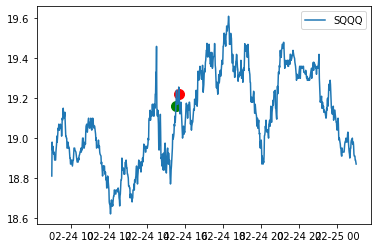

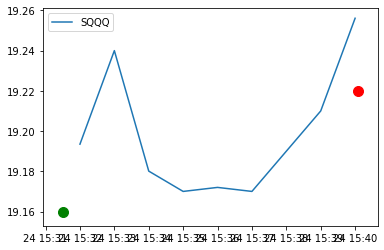

Delta = 0.05999999999999872


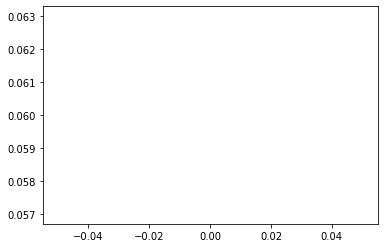

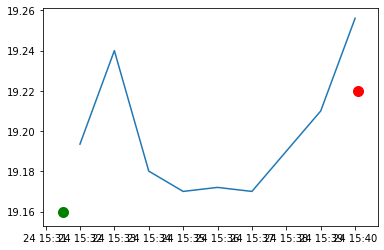

buy time:2020-02-24T15:31:29.869011084Z sell time:2020-02-24T15:40:04.440820705Z
{'rsi': 69.42248882987234, 'macd1': [0.056256896822031166, 0.06202933962989832, 0.06345185932688935, 0.06623643334217277, 0.0716518524898504], 'macd2': [0.13357876212774755, 0.13326023936929943, 0.13227424903556795, 0.13163536028944023, 0.1316367099711684], 'macd_signal': [0.04251629553602926, 0.04641890435480307, 0.04982549534922033, 0.05310768294781082, 0.05681651685621873]}
{'rsi': 68.34887065420145, 'macd': [0.048355547859568304, 0.04648024240571047, 0.045454286955877166, 0.045103486774763724, 0.04476385693526197], 'scalp': 0, 'bail_out': 1, 'movement': 0.003131524008350664, 'too_close': 1, 'macd_signal': [0.04362176375056428, 0.04419345948159352, 0.04444562497645025, 0.04457719733611294, 0.044614529255942746], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00014932767931922358}
IAG analysis for run 70
20

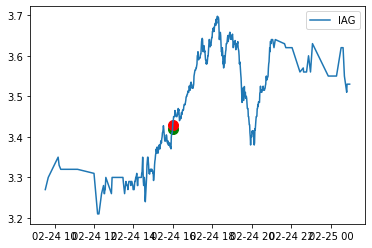

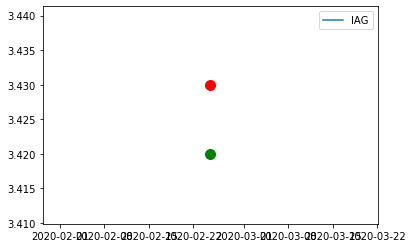

Delta = 0.010000000000000231


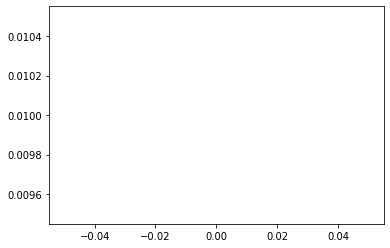

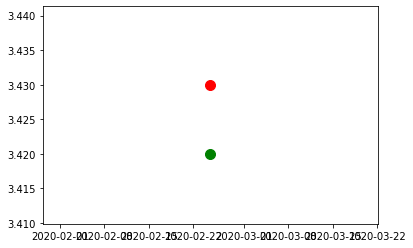

buy time:2020-02-24T15:59:04.016670944Z sell time:2020-02-24T16:00:56.692770004Z
{'rsi': 67.04351473323723, 'macd1': [-0.0011686918556907955, 0.0007836683288378055, 0.0025516580081257345, 0.003907756383543681, 0.005723414582135433], 'macd2': [0.015618171662867386, 0.015559173770028245, 0.015529589265228516, 0.015477533166626145, 0.015564821764966652], 'macd_signal': [-7.580065144064882e-05, 9.609314461504206e-05, 0.0005872061173171805, 0.0012513161705624807, 0.0021457358528770712]}
{'rsi': 71.04224389575072, 'macd': [-2.7683434067782287e-05, 0.0011644936980697018, 0.0020783395971628593, 0.003542656666623234, 0.004990921179623076], 'scalp': 0, 'bail_out': 1, 'movement': 0.0034502923976608285, 'too_close': 0, 'macd_signal': [-0.0007011783684388101, -0.0003280439551371077, 0.00015323275532288573, 0.0008311175375829555, 0.0016630782659909796], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00

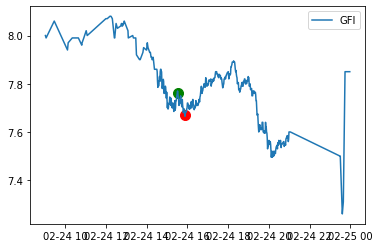

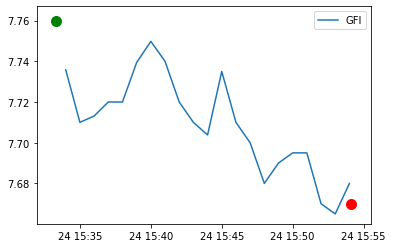

Delta = -0.08999999999999986


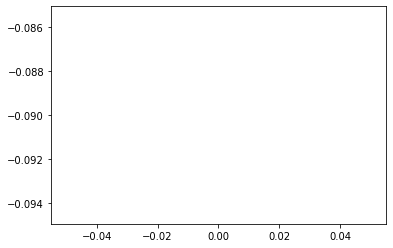

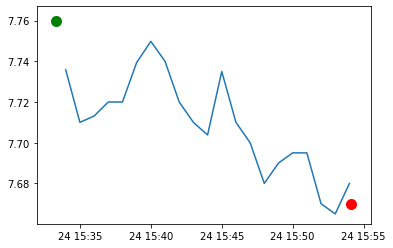

buy time:2020-02-24T15:33:20.762030668Z sell time:2020-02-24T15:54:07.836381557Z
{'rsi': 56.72690821845624, 'macd1': [-0.0015018215845366, 0.0011095749067520089, 0.003940616888169046, 0.006911483205368718, 0.008362600881746118], 'macd2': [0.017802430579572537, 0.017756359333450433, 0.01784550952350994, 0.018058925176942076, 0.018066455651887914], 'macd_signal': [-0.005662711194775046, -0.004308253974469635, -0.0026584798019418984, -0.000744487200479775, 0.0010769304159654039]}
{'rsi': 37.71326343953132, 'macd': [-0.0054759232295857885, -0.005827809157340269, -0.006026320150948727, -0.007401441442709711, -0.008376841911059252], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [-0.002226248723045697, -0.0029465608099046117, -0.0035625126781134346, -0.00433029843103269, -0.0051396071270380025], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0032372347840212493}
LAB

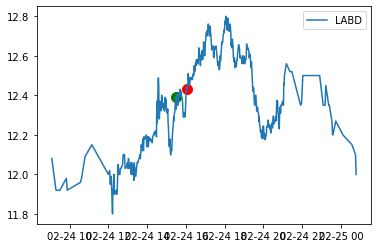

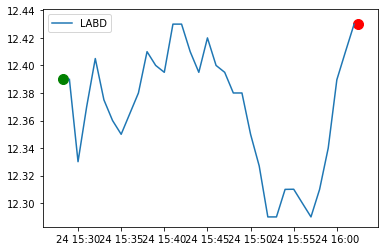

Delta = 0.03999999999999915


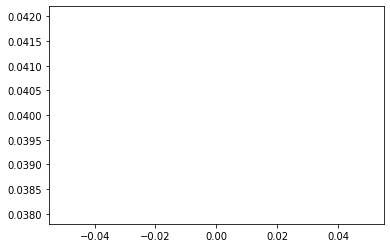

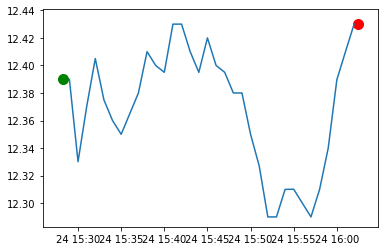

buy time:2020-02-24T15:28:13.504801803Z sell time:2020-02-24T16:02:23.906603891Z
{'rsi': 69.0155039452318, 'macd1': [0.011754028801323813, 0.017112474708566694, 0.021913394154886134, 0.02781823538314221, 0.03531840175419099], 'macd2': [0.08429962291025639, 0.08354642379498856, 0.08287977171205618, 0.08261368393529622, 0.08287648972895312], 'macd_signal': [-0.003980177346816636, 0.00023835306426003063, 0.004573361282385251, 0.009222336102536643, 0.014441549232867511]}
{'rsi': 64.84005897144093, 'macd': [-0.009381915557575837, -0.007836246752823683, -0.003953436687396561, 0.00018321319069514175, 0.004443158378938605], 'scalp': 0, 'bail_out': 1, 'movement': 0.003228410008070956, 'too_close': 0, 'macd_signal': [-0.002012528040140775, -0.0031772717826773567, -0.0033325047636211975, -0.0026293611727579297, -0.0012148572624186226], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00565801564135722

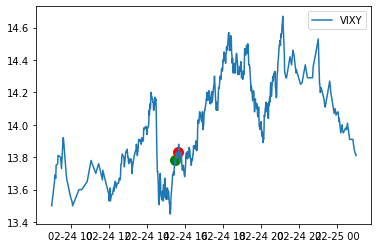

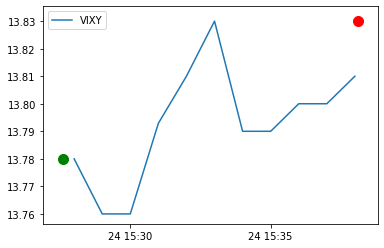

Delta = 0.05000000000000071


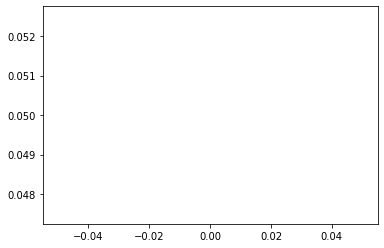

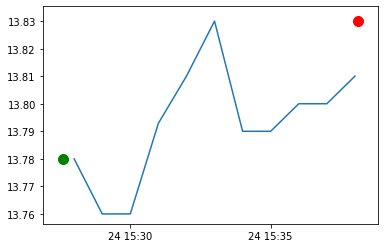

buy time:2020-02-24T15:27:35.448710613Z sell time:2020-02-24T15:38:05.628796743Z
{'rsi': 69.20536886152004, 'macd1': [0.04345981244745012, 0.04752193904928603, 0.04856751471682941, 0.05202410517183509, 0.058127996779925084], 'macd2': [0.11687143649180065, 0.11624428220708971, 0.1151614916681254, 0.11462084912641046, 0.11473980079174773], 'macd_signal': [0.030760587267145714, 0.03411285762357378, 0.037003789042224906, 0.040007852268146946, 0.043631881170502575]}
{'rsi': 67.8593803375356, 'macd': [0.03953653634942711, 0.038030281604285676, 0.036882157366457946, 0.03550852604650778, 0.03517181948490489], 'scalp': 0, 'bail_out': 1, 'movement': 0.0031204644412192338, 'too_close': 1, 'macd_signal': [0.035236504580496555, 0.03579525998525438, 0.03601263946149509, 0.03591181677849763, 0.03576381731977908], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005919978348741944}
VXX analysis for run 7

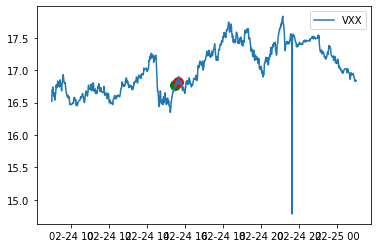

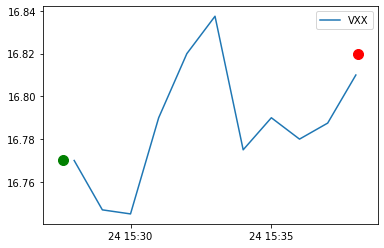

Delta = 0.05000000000000071


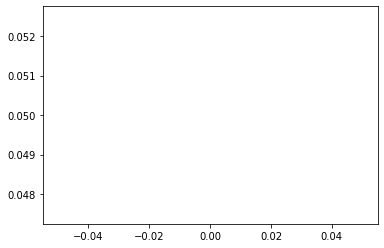

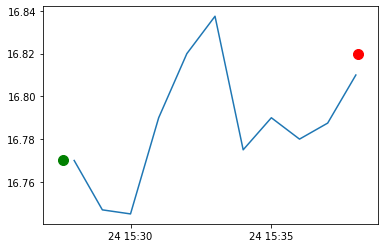

buy time:2020-02-24T15:27:35.74271219Z sell time:2020-02-24T15:38:03.827500831Z
{'rsi': 68.97614086350966, 'macd1': [0.05347269402584587, 0.058589655090880655, 0.061133260995497096, 0.06522146207751334, 0.07206866848561688], 'macd2': [0.1424084688371252, 0.14169323070374773, 0.1406486341952622, 0.1400224002477195, 0.14010194686335709], 'macd_signal': [0.03738130276801908, 0.04162297323259139, 0.04552503078517253, 0.049464317043640696, 0.05398518733203593]}
{'rsi': 66.39629212925068, 'macd': [0.05039430050582894, 0.048161880592481054, 0.04657607441854239, 0.04421601669315578, 0.044394984482554634], 'scalp': 0, 'bail_out': 1, 'movement': 0.003571854502086998, 'too_close': 0, 'macd_signal': [0.042043306844197756, 0.04326702159385441, 0.04392883215879201, 0.04398626906566476, 0.04406801214904273], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003269723335119004}
CODX analysis for run 70
202

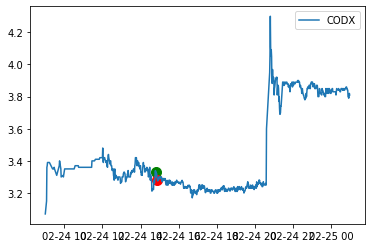

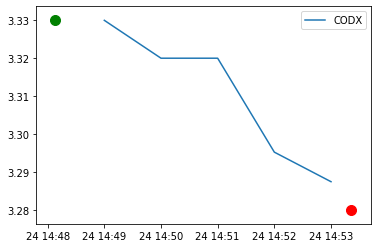

Delta = -0.050000000000000266


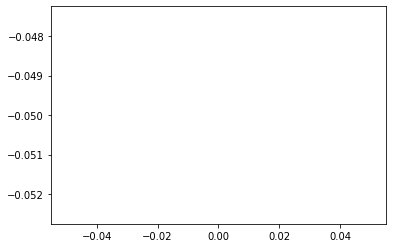

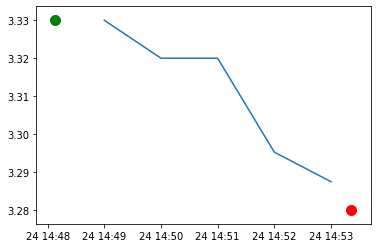

buy time:2020-02-24T14:48:08.212005484Z sell time:2020-02-24T14:53:21.626134862Z
{'rsi': 59.411402006875704, 'macd1': [0.050286419991047104, 0.0502183986435889, 0.05118825771730595, 0.05453970562158794, 0.05624081488424082], 'macd2': [0.02878104769975698, 0.02991644149269934, 0.03123306498393852, 0.033030993170026335, 0.0345715404645115], 'macd_signal': [0.05116441834439003, 0.0509752144042298, 0.05101782306684503, 0.051722199577793615, 0.052625922639083056]}
{'rsi': 46.94289420924584, 'macd': [0.032195544580500446, 0.03162125495114365, 0.030763090889942113, 0.02840655927225333, 0.02541177412506368], 'scalp': 0, 'bail_out': 0, 'movement': -0.016786570743405293, 'too_close': 1, 'macd_signal': [0.03156852635702419, 0.03157907207584808, 0.03141587583866688, 0.030814012525384172, 0.029733564845320075], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004321790720256395}
BIS analysis for run 70

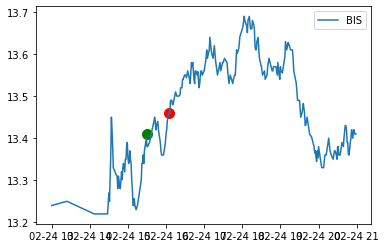

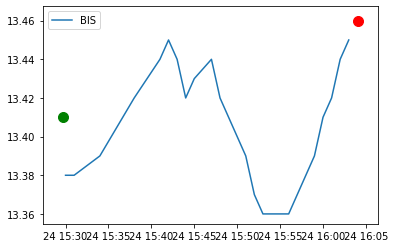

Delta = 0.05000000000000071


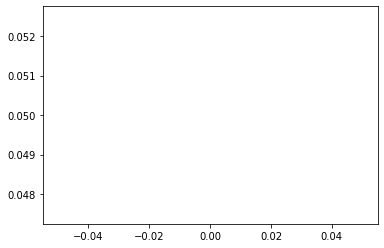

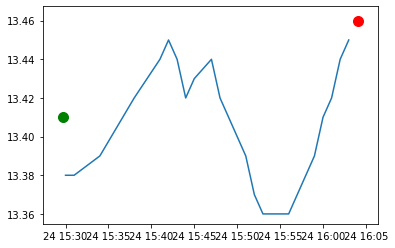

buy time:2020-02-24T15:29:39.249100896Z sell time:2020-02-24T16:04:01.146114079Z
{'rsi': 67.55270368302266, 'macd1': [0.01668157891344002, 0.020221970440472248, 0.023563052458058564, 0.02670990529282591, 0.030466443493367024], 'macd2': [0.06017779351996033, 0.0600022898280983, 0.05990479156568718, 0.05987921672839569, 0.06007979067180891], 'macd_signal': [0.013539237477606167, 0.014875784070179383, 0.01661323774775522, 0.018632571256769356, 0.02099934570408889]}
{'rsi': 65.38434534846009, 'macd': [0.004001206052164363, 0.004528535911532572, 0.005400110660241708, 0.007048089546765723, 0.009279656347345622], 'scalp': 0, 'bail_out': 1, 'movement': 0.0037285607755406943, 'too_close': 0, 'macd_signal': [0.011020904918803807, 0.00972243111734956, 0.00885796702592799, 0.008495991530095537, 0.008652724493545554], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006269318538000678}


In [15]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)


        for trade in trade_details[run_id][symbol]:
            print(trade[0], trade[1])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)

        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
        for trade in trade_details[run_id][symbol]:
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])
